# Strain mapping with py4DSTEM

The code in this directory calculates and visualizes strain maps.

The procedure is divided into 7 steps, each in a single notebook.  This is notebook:
1. Get probe template
2. Get the Bragg disks
3. Determine the diffraction shifts
4. Calculate lattice vectors
5. Refine lattice vectors
6. Calculate strain
7. **Visualize strain maps**

# Notebook 7: Calculate strain

In this step plots of the strain maps are generated, as follows:

* Generate a mask
* Apply smoothing
* Plot

### Import packages, load data

In [58]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from scipy.optimize import curve_fit
from time import time
from gc import collect
from numpy.linalg import lstsq
from scipy.ndimage.morphology import binary_closing
from scipy.ndimage.filters import maximum_filter
from scipy.signal import medfilt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from py4DSTEM.process.datastructure import DataCube, DiffractionSlice, RealSlice, PointList, PointListArray

In [6]:
# # Load the lattice vectors maps
# fp_uvmap = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/processing/strain_maps.h5"
# browser = py4DSTEM.readwrite.FileBrowser(fp_uvmap)
# browser.show_dataobjects()
# strain_maps = browser.get_dataobject(0)

# # Load the DF image
# fp_DFimage = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/processing/DF_image.h5"
# browser = py4DSTEM.readwrite.FileBrowser(fp_DFimage)
# browser.show_dataobjects()
# DFimage = browser.get_dataobject(0)

In [7]:
# Load the lattice vectors maps
fp_uvmap = "/home/ben/Data/20180905_FePO4_unlithiated/processing/strain_maps.h5"
browser = py4DSTEM.readwrite.FileBrowser(fp_uvmap)
browser.show_dataobjects()
strain_maps = browser.get_dataobject(0)

# Load the DF image
fp_DFimage = "/home/ben/Data/20180905_FePO4_unlithiated/processing/DF_image.h5"
browser = py4DSTEM.readwrite.FileBrowser(fp_DFimage)
browser.show_dataobjects()
DF_image = browser.get_dataobject(0)

 Index                  Name                        Type        
   0    strain_maps                         RealSlice           
 Index                  Name                        Type        
   0    realslice_0                         RealSlice           


### Create strain map plots

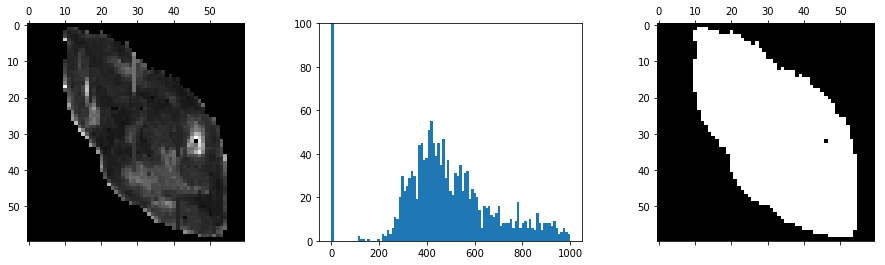

In [5]:
# Make a mask from the virtual dark-field image

mask = (DF_image.data2D>0)

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,4))
ax1.matshow(DF_image.data2D)
ax2.hist(DF_image.data2D.ravel(),bins=np.linspace(0,1000,100))
ax2.set_ylim([0,100])
ax3.matshow(mask)
plt.show()

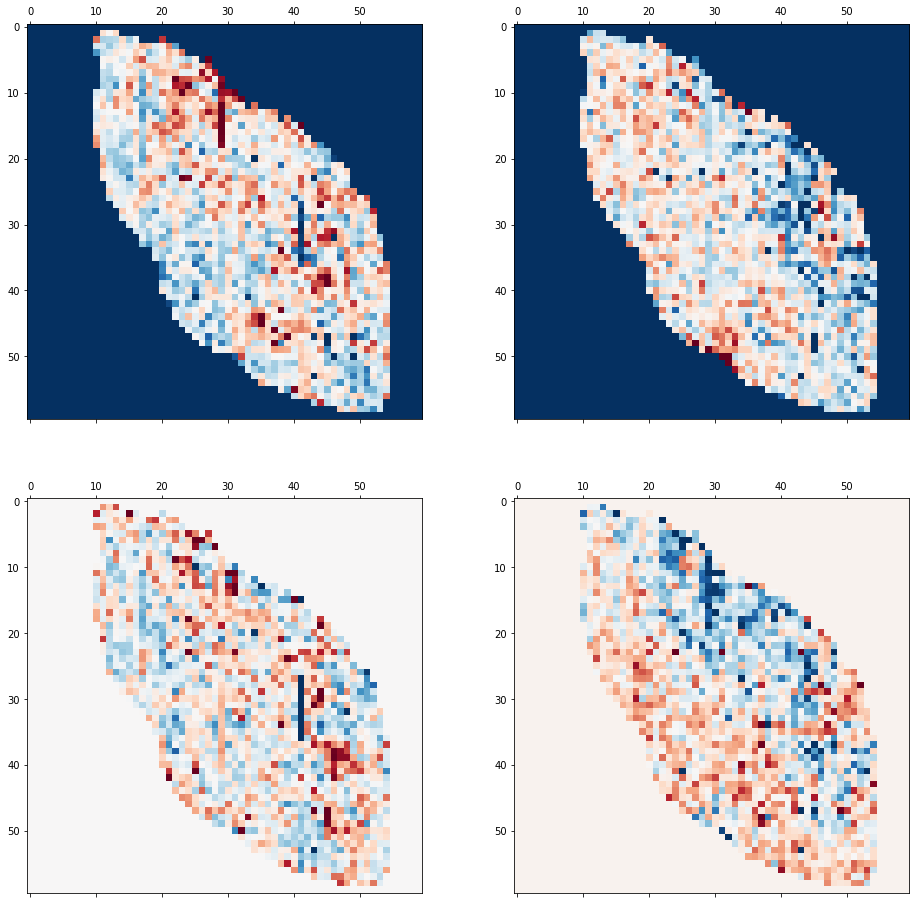

In [10]:
# Plot

n_stds=2.5

e_uu_ave, e_uu_std = np.average(strain_maps.data2D['e_uu'][mask]),np.std(strain_maps.data2D['e_uu'][mask])
e_vv_ave, e_vv_std = np.average(strain_maps.data2D['e_vv'][mask]),np.std(strain_maps.data2D['e_vv'][mask])
e_uv_ave, e_uv_std = np.average(strain_maps.data2D['e_uv'][mask]),np.std(strain_maps.data2D['e_uv'][mask])
theta_ave, theta_std = np.average(strain_maps.data2D['theta'][mask]),np.std(strain_maps.data2D['theta'][mask])

fig,((ax11,ax12),(ax21,ax22)) = plt.subplots(2,2,figsize=(16,16))
ax11.matshow(strain_maps.data2D['e_uu'],vmin=-n_stds*e_uu_std, vmax=n_stds*e_uu_std, cmap="RdBu")
ax12.matshow(strain_maps.data2D['e_vv'],vmin=-n_stds*e_vv_std, vmax=n_stds*e_vv_std, cmap="RdBu")
ax21.matshow(strain_maps.data2D['e_uv'],vmin=-n_stds*e_uv_std, vmax=n_stds*e_uv_std, cmap="RdBu")
ax22.matshow(strain_maps.data2D['theta'],vmin=theta_ave-n_stds*theta_std, vmax=theta_ave+n_stds*theta_std, cmap="RdBu")
plt.show()

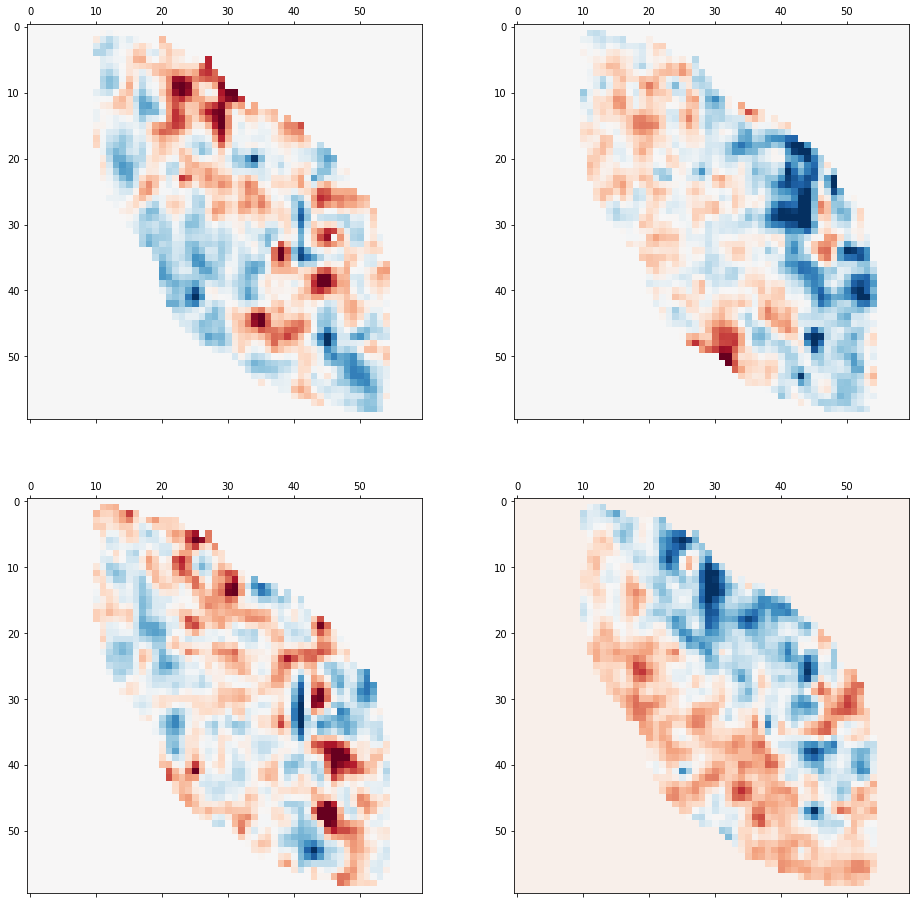

In [15]:
# Plot, with gaussian smoothing

sigma = .8
n_stds=3

e_uu_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['e_uu'], medfilt(np.where(mask,strain_maps.data2D['e_uu'],0),kernel_size=3)),sigma),0)
e_vv_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['e_vv'], medfilt(np.where(mask,strain_maps.data2D['e_vv'],0),kernel_size=3)),sigma),0)
e_uv_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['e_uv'], medfilt(np.where(mask,strain_maps.data2D['e_uv'],0),kernel_size=3)),sigma),0)
theta_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['theta'], medfilt(np.where(mask,strain_maps.data2D['theta'],0),kernel_size=3)),sigma),0)

e_uu_ave, e_uu_std = np.average(e_uu_smoothed[mask]),np.std(e_uu_smoothed[mask])
e_vv_ave, e_vv_std = np.average(e_vv_smoothed[mask]),np.std(e_vv_smoothed[mask])
e_uv_ave, e_uv_std = np.average(e_uv_smoothed[mask]),np.std(e_uv_smoothed[mask])
theta_ave, theta_std = np.average(theta_smoothed[mask]),np.std(theta_smoothed[mask])

fig,((ax11,ax12),(ax21,ax22)) = plt.subplots(2,2,figsize=(16,16))
ax11.matshow(e_uu_smoothed,vmin=-n_stds*e_uu_std, vmax=n_stds*e_uu_std, cmap="RdBu")
ax12.matshow(e_vv_smoothed,vmin=-n_stds*e_vv_std, vmax=n_stds*e_vv_std, cmap="RdBu")
ax21.matshow(e_uv_smoothed,vmin=-n_stds*e_uv_std, vmax=n_stds*e_uv_std, cmap="RdBu")
ax22.matshow(theta_smoothed,vmin=theta_ave-n_stds*theta_std, vmax=theta_ave+n_stds*theta_std, cmap="RdBu")
plt.show()

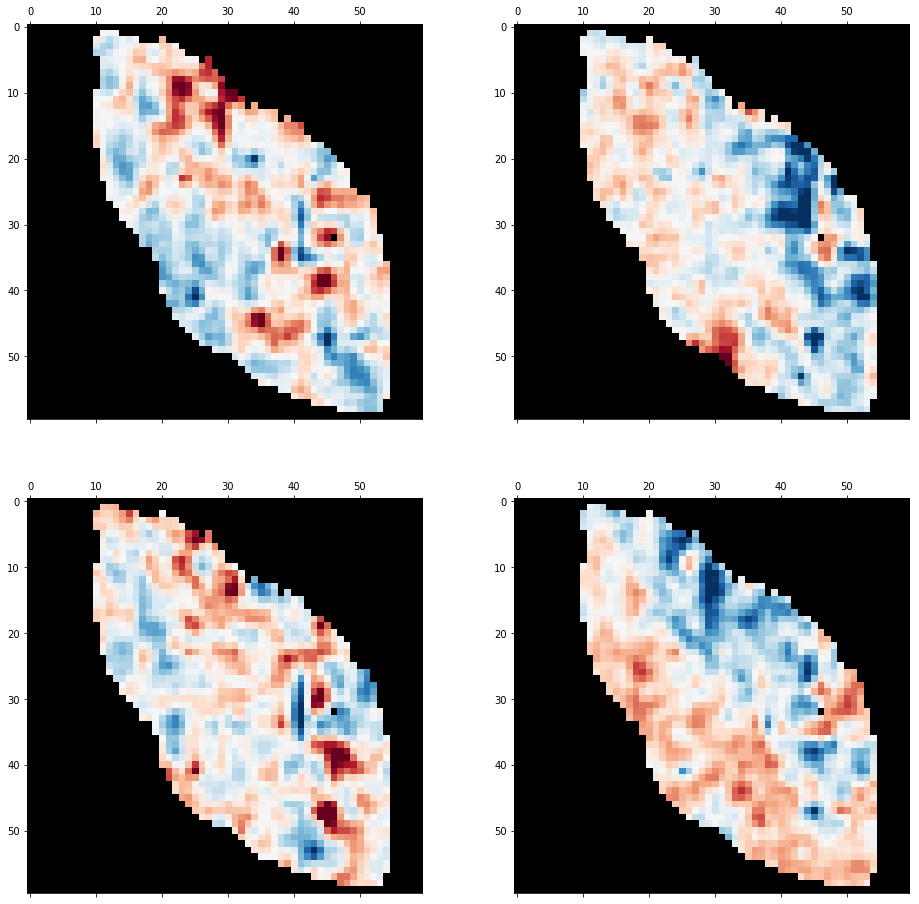

In [92]:
# Plot, with gaussian smoothing, and setting unknown pixels to black

sigma = .8
n_stds=3

plot_mask = np.ma.masked_where(mask, np.ones_like(mask))

e_uu_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['e_uu'], medfilt(np.where(mask,strain_maps.data2D['e_uu'],0),kernel_size=3)),sigma),0)
e_vv_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['e_vv'], medfilt(np.where(mask,strain_maps.data2D['e_vv'],0),kernel_size=3)),sigma),0)
e_uv_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['e_uv'], medfilt(np.where(mask,strain_maps.data2D['e_uv'],0),kernel_size=3)),sigma),0)
theta_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['theta'], medfilt(np.where(mask,strain_maps.data2D['theta'],0),kernel_size=3)),sigma),0)

e_uu_ave, e_uu_std = np.average(e_uu_smoothed[mask]),np.std(e_uu_smoothed[mask])
e_vv_ave, e_vv_std = np.average(e_vv_smoothed[mask]),np.std(e_vv_smoothed[mask])
e_uv_ave, e_uv_std = np.average(e_uv_smoothed[mask]),np.std(e_uv_smoothed[mask])
theta_ave, theta_std = np.average(theta_smoothed[mask]),np.std(theta_smoothed[mask])

# Plot
fig,((ax11,ax12),(ax21,ax22)) = plt.subplots(2,2,figsize=(16,16))

ax11.matshow(e_uu_smoothed,vmin=-n_stds*e_uu_std, vmax=n_stds*e_uu_std, cmap="RdBu")
ax12.matshow(e_vv_smoothed,vmin=-n_stds*e_vv_std, vmax=n_stds*e_vv_std, cmap="RdBu")
ax21.matshow(e_uv_smoothed,vmin=-n_stds*e_uv_std, vmax=n_stds*e_uv_std, cmap="RdBu")
ax22.matshow(theta_smoothed,vmin=theta_ave-n_stds*theta_std, vmax=theta_ave+n_stds*theta_std, cmap="RdBu")

ax11.matshow(plot_mask,cmap='gray')
ax12.matshow(plot_mask,cmap='gray')
ax21.matshow(plot_mask,cmap='gray')
ax22.matshow(plot_mask,cmap='gray')

plt.show()

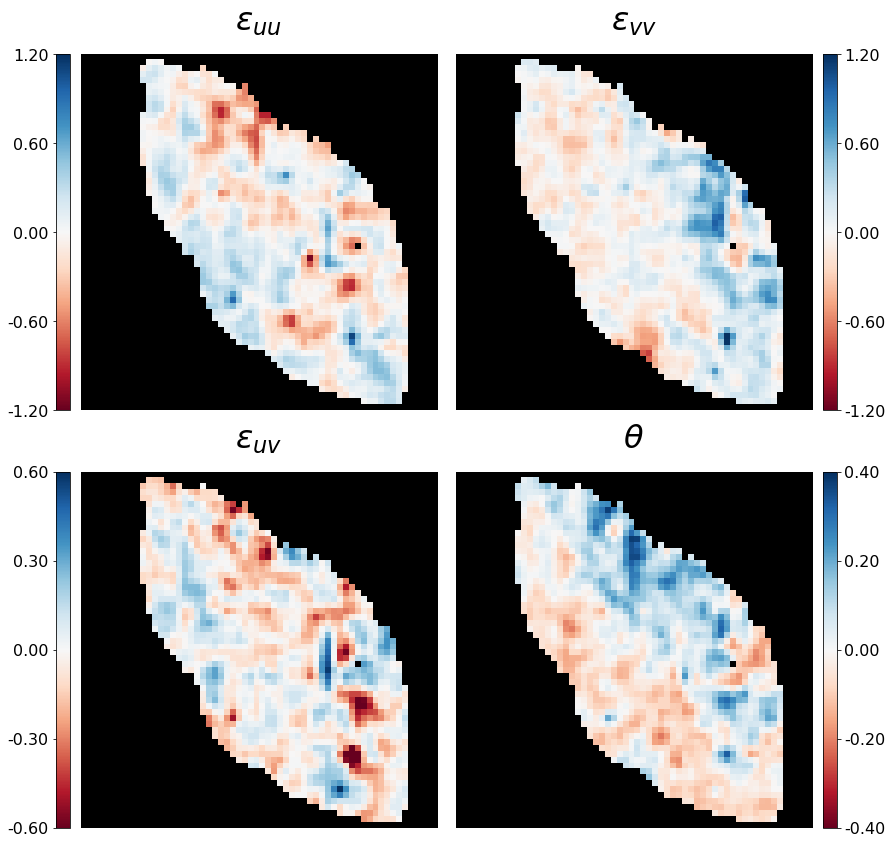

In [128]:
# Add colorbars, labels, and formatting
# Colorbar labels in 

sigma = .8
titlesize=32
ticklabelsize=16

# Set colorscales
automate_colorscale = False
n_stds=3

e_uu_range = [-1.2,1.2] # In percentage
e_vv_range = [-1.2,1.2] # In percentage
e_uv_range = [-0.6,0.6] # In percentage
theta_range = [-.4,.4] # In degrees



# Get smoothed image, mask, and colorscale ranges
plot_mask = np.ma.masked_where(mask, np.ones_like(mask))

e_uu_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['e_uu'], medfilt(np.where(mask,strain_maps.data2D['e_uu'],0),kernel_size=3)),sigma),0)
e_vv_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['e_vv'], medfilt(np.where(mask,strain_maps.data2D['e_vv'],0),kernel_size=3)),sigma),0)
e_uv_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['e_uv'], medfilt(np.where(mask,strain_maps.data2D['e_uv'],0),kernel_size=3)),sigma),0)
theta_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['theta'], medfilt(np.where(mask,strain_maps.data2D['theta'],0),kernel_size=3)),sigma),0)

e_uu_ave, e_uu_std = np.average(e_uu_smoothed[mask]),np.std(e_uu_smoothed[mask])
e_vv_ave, e_vv_std = np.average(e_vv_smoothed[mask]),np.std(e_vv_smoothed[mask])
e_uv_ave, e_uv_std = np.average(e_uv_smoothed[mask]),np.std(e_uv_smoothed[mask])
theta_ave, theta_std = np.average(theta_smoothed[mask]),np.std(theta_smoothed[mask])

if automate_colorscale:
    e_uu_range = [-n_stds*e_uu_std*100,n_stds*e_uu_std*100]
    e_vv_range = [-n_stds*e_vv_std*100,n_stds*e_vv_std*100]
    e_uv_range = [-n_stds*e_uv_std*100,n_stds*e_uv_std*100]
    theta_range = [-n_stds*theta_std*180./np.pi,n_stds*theta_std*180/np.pi]

### Plot ###
fig,((ax11,ax12),(ax21,ax22)) = plt.subplots(2,2,
                                             figsize=(14,15),
                                             gridspec_kw={'wspace':0.05,'hspace':0.05})

cax11 = ax11.matshow(e_uu_smoothed,vmin=e_uu_range[0]/100., vmax=e_uu_range[1]/100., cmap="RdBu")
cax12 = ax12.matshow(e_vv_smoothed,vmin=e_vv_range[0]/100., vmax=e_vv_range[1]/100., cmap="RdBu")
cax21 = ax21.matshow(e_uv_smoothed,vmin=e_uv_range[0]/100., vmax=e_uv_range[1]/100., cmap="RdBu")
cax22 = ax22.matshow(theta_smoothed,vmin=theta_range[0]*np.pi/180., vmax=theta_range[1]*np.pi/180., cmap="RdBu")

# Black overlay
ax11.matshow(plot_mask,cmap='gray')
ax12.matshow(plot_mask,cmap='gray')
ax21.matshow(plot_mask,cmap='gray')
ax22.matshow(plot_mask,cmap='gray')

# Colorbars
divider11 = make_axes_locatable(ax11)
divider12 = make_axes_locatable(ax12)
divider21 = make_axes_locatable(ax21)
divider22 = make_axes_locatable(ax22)
cbax11 = divider11.append_axes("left", size="4%", pad=0.15)
cbax12 = divider12.append_axes("right", size="4%", pad=0.15)
cbax21 = divider21.append_axes("left", size="4%", pad=0.15)
cbax22 = divider22.append_axes("right", size="4%", pad=0.15)

cb11 = plt.colorbar(cax11, cax=cbax11, ticks=np.linspace(e_uu_range[0]/100.,e_uu_range[1]/100.,5,endpoint=True))
cb12 = plt.colorbar(cax12, cax=cbax12, ticks=np.linspace(e_vv_range[0]/100.,e_vv_range[1]/100.,5,endpoint=True))
cb21 = plt.colorbar(cax21, cax=cbax21, ticks=np.linspace(e_uv_range[0]/100.,e_uv_range[1]/100.,5,endpoint=True))
cb22 = plt.colorbar(cax22, cax=cbax22, ticks=np.linspace(theta_range[0]*np.pi/180.,theta_range[1]*np.pi/180.,5,endpoint=True))

cb11.ax.set_yticklabels(['{:.2f}'.format(val) for val in np.linspace(e_uu_range[0],e_uu_range[1],5,endpoint=True)],size=ticklabelsize)
cb12.ax.set_yticklabels(['{:.2f}'.format(val) for val in np.linspace(e_vv_range[0],e_vv_range[1],5,endpoint=True)],size=ticklabelsize)
cb21.ax.set_yticklabels(['{:.2f}'.format(val) for val in np.linspace(e_uv_range[0],e_uv_range[1],5,endpoint=True)],size=ticklabelsize)
cb22.ax.set_yticklabels(['{:.2f}'.format(theta) for theta in np.linspace(theta_range[0],theta_range[1],5,endpoint=True)],size=ticklabelsize)

cbax11.yaxis.set_ticks_position('left')
cbax21.yaxis.set_ticks_position('left')



ax11.set_title(r'$\epsilon_{uu}$',size=titlesize)
ax12.set_title(r'$\epsilon_{vv}$',size=titlesize)
ax21.set_title(r'$\epsilon_{uv}$',size=titlesize)
ax22.set_title(r'$\theta$',size=titlesize)

ax11.axis('off')
ax12.axis('off')
ax21.axis('off')
ax22.axis('off')

plt.show()

### Save strain maps

In [13]:
# Save

savepath = "/home/ben/Data/20180905_FePO4_unlithiated/processing/strain_maps.h5"
py4DSTEM.readwrite.save_dataobject(strain_maps,savepath)

Creating file /home/ben/Data/20180905_FePO4_unlithiated/processing/strain_maps.h5...
Writing metadata...
Done.


In [106]:
# # Save

# savepath = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/processing/strain_maps.h5"
# py4DSTEM.readwrite.save_dataobject(strain_maps,savepath)